## **ECON 470 Hwk4-1**

**Author:** Ilse Novis 

**Due Date:** 4/23/2025  

[GitHub Repository](https://github.com/ilsenovis18/ECON470HW5)

\newpage

# Summarize the Data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from linearmodels.panel import PanelOLS
import patsy

# Load merged data
df = pd.read_csv('/Users/ilsenovis/Documents/GitHub/ECON470HW5/data/output/acs_medicaid.csv')

## **Question 1:** Plot the share of the adult population with direct purchase health insurance over time.

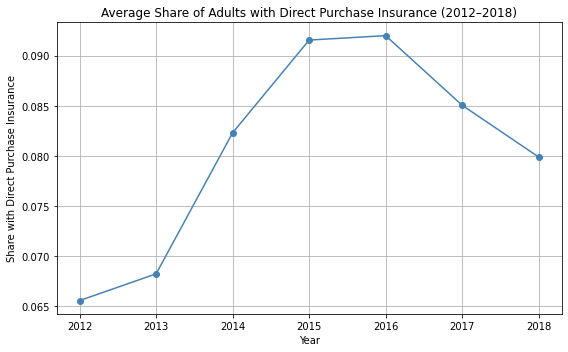

In [3]:
# Q1
# Calculate share of direct purchase insurance
df['share_direct'] = df['ins_direct'] / df['adult_pop']

# Group by year and calculate average share
trend = df.groupby('year', as_index=False)['share_direct'].mean()

# Plot
plt.figure(figsize=(8, 5))
plt.plot(trend['year'], trend['share_direct'], marker='o', linestyle='-', color='steelblue')
plt.title("Average Share of Adults with Direct Purchase Insurance (2012–2018)")
plt.xlabel("Year")
plt.ylabel("Share with Direct Purchase Insurance")
plt.grid(True)
plt.tight_layout()
plt.show()

\newpage

## **Question 2:** Discuss the reduction in direct purchase health insurance in later years. Can you list a couple of policies that might have affected the success of the direct purchase insurance market?

1. Repeal of the Individual Mandate Penalty (Effective 2019)
	
	- Though passed in late 2017 (Tax Cuts and Jobs Act), anticipation of the penalty’s removal may have influenced enrollment decisions in 2018.
	
	- Without a tax penalty, some healthy individuals likely opted out of buying coverage, causing a decline in enrollment and rising premiums for those who remained.

2. Cutbacks in ACA Outreach and Enrollment Support
	
	- The federal government significantly reduced funding for advertising and navigator programs during Open Enrollment periods (starting in 2017).
	
	- This made it harder for new enrollees to access information or get assistance, particularly impacting low-income or tech-averse individuals.

3. Expansion of Non-ACA-Compliant Plans
	
	- In 2018, the Trump administration expanded the availability of short-term, limited-duration insurance plans.
	
	- These plans are often cheaper but lack essential health benefits and consumer protections, drawing healthier individuals away from ACA-compliant markets and increasing risk-pooling issues.

\newpage

## **Question 3:** Plot the share of the adult population with Medicaid over time.



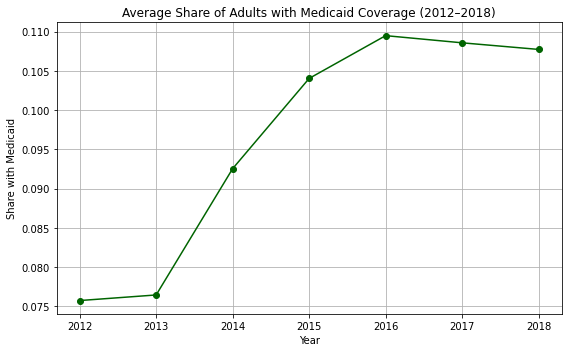

In [4]:
## Q3
# Calculate share of adult population with Medicaid
df['share_medicaid'] = df['ins_medicaid'] / df['adult_pop']

# Group by year and calculate average share
medicaid_trend = df.groupby('year', as_index=False)['share_medicaid'].mean()

# Plot
plt.figure(figsize=(8, 5))
plt.plot(medicaid_trend['year'], medicaid_trend['share_medicaid'], marker='o', linestyle='-', color='darkgreen')
plt.title("Average Share of Adults with Medicaid Coverage (2012–2018)")
plt.xlabel("Year")
plt.ylabel("Share with Medicaid")
plt.grid(True)
plt.tight_layout()
plt.show()

\newpage

## **Question 4:** Plot the share of uninsured over time, separately by states that expanded Medicaid in 2014 versus those that did not. Drop all states that expanded after 2014.

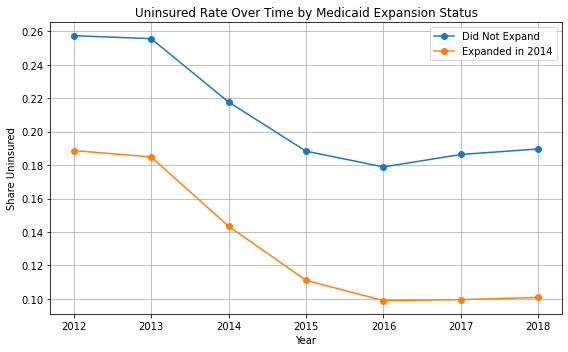

In [5]:
# Identify states that expanded in 2014 or never expanded
expansion_2014_states = df[df['expand_year'] == 2014]['State'].unique()
never_expanded_states = df[df['expand_ever'] == False]['State'].unique()

# Combine them into one list
keep_states = list(set(expansion_2014_states).union(set(never_expanded_states)))

# Filter dataset
filtered_df = df[df['State'].isin(keep_states)].copy()

# Assign group labels explicitly
filtered_df['expansion_group'] = filtered_df['State'].apply(
    lambda x: 'Expanded in 2014' if x in expansion_2014_states else 'Did Not Expand'
)

# Group by year and expansion status, then average
uninsured_trend = (
    filtered_df.groupby(['year', 'expansion_group'])['uninsured']
    .sum()
    .div(filtered_df.groupby(['year', 'expansion_group'])['adult_pop'].sum())
    .reset_index(name='share_uninsured')
)

# Plot
plt.figure(figsize=(8, 5))
for label, grp in uninsured_trend.groupby('expansion_group'):
    plt.plot(grp['year'], grp['share_uninsured'], marker='o', label=label)

plt.title("Uninsured Rate Over Time by Medicaid Expansion Status")
plt.xlabel("Year")
plt.ylabel("Share Uninsured")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

\newpage

# Estimate ATEs

## **Question 5:** Calculate the average percent of uninsured individuals in 2012 and 2015, separately for expansion and non-expansion states. Present your results in a basic 2x2 DD table.

In [31]:
# Filter to 2012 and 2015
df_dd = df[df['year'].isin([2012, 2015])].copy()

# Keep only states that expanded in 2014 or never expanded
expansion_2014_states = df[df['expand_year'] == 2014]['State'].unique()
never_expanded_states = df[df['expand_ever'] == False]['State'].unique()
keep_states = list(set(expansion_2014_states).union(set(never_expanded_states)))
df_dd = df_dd[df_dd['State'].isin(keep_states)].copy()

# Assign treatment group
df_dd['group'] = df_dd['State'].apply(
    lambda x: 'Expanded' if x in expansion_2014_states else 'Not Expanded'
)

# Calculate average uninsurance rate by year and group
ate_table = (
    df_dd.groupby(['group', 'year'])[['uninsured', 'adult_pop']]
    .sum()
    .reset_index()
)

ate_table['uninsured_rate'] = ate_table['uninsured'] / ate_table['adult_pop']

# Pivot for 2x2 display
dd_pivot = ate_table.pivot(index='group', columns='year', values='uninsured_rate')
dd_pivot['Change'] = dd_pivot[2015] - dd_pivot[2012]

# DiD estimate
did_estimate = dd_pivot.loc['Expanded', 'Change'] - dd_pivot.loc['Not Expanded', 'Change']

# Display
print("\nQ5: Difference-in-Differences Table (Uninsurance Rates)")
print(dd_pivot)
print(f"\nEstimated ATE (Difference-in-Differences): {did_estimate:.4f}")


Q5: Difference-in-Differences Table (Uninsurance Rates)
year              2012      2015    Change
group                                     
Expanded      0.188707  0.111088 -0.077619
Not Expanded  0.257413  0.188323 -0.069090

Estimated ATE (Difference-in-Differences): -0.0085


\newpage

## **Question 6:** Estimate the effect of Medicaid expansion on the uninsurance rate using a standard DD regression estimator, again focusing only on states that expanded in 2014 versus those that never expanded.

In [23]:
# Subset to relevant states
df_reg_all_years = df[df['State'].isin(keep_states)].copy()

# Create DiD variables
df_reg_all_years['treatment'] = df_reg_all_years['State'].apply(lambda x: 1 if x in expansion_2014_states else 0)
df_reg_all_years['post'] = df_reg_all_years['year'].apply(lambda x: 1 if x >= 2014 else 0)
df_reg_all_years['interaction'] = df_reg_all_years['treatment'] * df_reg_all_years['post']

# Calculate uninsured rate
df_reg_all_years['uninsured_rate'] = df_reg_all_years['uninsured'] / df_reg_all_years['adult_pop']

# Fit regression
model = smf.ols('uninsured_rate ~ treatment + post + interaction', data=df_reg_all_years).fit()

# Print results
print(model.summary())
print(f"\nEstimated ATE (DiD Regression across all years): {model.params['interaction']:.4f}")

                            OLS Regression Results                            
Dep. Variable:         uninsured_rate   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     75.03
Date:                Tue, 15 Apr 2025   Prob (F-statistic):           2.10e-37
Time:                        11:26:55   Log-Likelihood:                 593.48
No. Observations:                 350   AIC:                            -1179.
Df Residuals:                     346   BIC:                            -1164.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.2229      0.010     22.329      

\newpage

## **Question 7:** Include state and year fixed effects in your estimates.

In [27]:
# Filter for states that expanded in 2014 or never expanded
fe_df = df[df['State'].isin(keep_states)].copy()

# Create DiD variables
fe_df['treatment'] = fe_df['State'].isin(expansion_2014_states).astype(int)
fe_df['post'] = (fe_df['year'] >= 2014).astype(int)
fe_df['interaction'] = fe_df['treatment'] * fe_df['post']
fe_df['uninsured_rate'] = fe_df['uninsured'] / fe_df['adult_pop']

# Set panel index
fe_df = fe_df.set_index(['State', 'year'])

# Estimate DiD with fixed effects
model_fe = PanelOLS.from_formula(
    formula="uninsured_rate ~ interaction + EntityEffects + TimeEffects",
    data=fe_df
).fit()

# Print summary
print("\nQ7: DiD Regression with State and Year Fixed Effects")
print(model_fe.summary)

# Extract and print ATE
ate_fe = model_fe.params['interaction']
print(f"\nEstimated ATE (w/ FE, all years): {ate_fe:.4f}")


Q7: DiD Regression with State and Year Fixed Effects
                          PanelOLS Estimation Summary                           
Dep. Variable:         uninsured_rate   R-squared:                        0.0206
Estimator:                   PanelOLS   R-squared (Between):             -0.0767
No. Observations:                 350   R-squared (Within):               0.1843
Date:                Tue, Apr 15 2025   R-squared (Overall):             -0.0633
Time:                        11:34:37   Log-likelihood                    1005.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      6.1670
Entities:                          50   P-value                           0.0136
Avg Obs:                       7.0000   Distribution:                   F(1,293)
Min Obs:                       7.0000                                           
Max Obs:                       7.0000   F-statistic (ro

\newpage

## **Question 8:** Repeat the analysis in question 7 but include all states (even those that expanded after 2014). Are your results different? If so, why?

In [26]:
# Create a fresh copy using ALL states and all available years
df_all = df.copy()

# Treatment: 1 if a state ever expanded Medicaid
df_all['treatment'] = df_all['expand_ever'].astype(int)

# Post: 1 if year >= expansion year (if expanded), otherwise 0
df_all['post'] = (df_all['year'] >= df_all['expand_year']).astype(int)

# Interaction: treatment * post
df_all['interaction'] = df_all['treatment'] * df_all['post']

# Outcome: uninsurance rate
df_all['uninsured_rate'] = df_all['uninsured'] / df_all['adult_pop']

# Set panel index
df_all = df_all.set_index(['State', 'year'])

# Estimate DiD with Entity (state) and Time (year) fixed effects
model_all = PanelOLS.from_formula(
    formula='uninsured_rate ~ interaction + EntityEffects + TimeEffects',
    data=df_all
).fit()

# Print summary and ATE
print("\nQ8: DiD Regression with All States and Years Included (w/ FE)")
print(model_all.summary)
print(f"\nEstimated ATE (All States, w/ FE): {model_all.params['interaction']:.4f}")


Q8: DiD Regression with All States and Years Included (w/ FE)
                          PanelOLS Estimation Summary                           
Dep. Variable:         uninsured_rate   R-squared:                        0.0206
Estimator:                   PanelOLS   R-squared (Between):             -0.0767
No. Observations:                 350   R-squared (Within):               0.1843
Date:                Tue, Apr 15 2025   R-squared (Overall):             -0.0633
Time:                        11:32:12   Log-likelihood                    1005.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      6.1670
Entities:                          50   P-value                           0.0136
Avg Obs:                       7.0000   Distribution:                   F(1,293)
Min Obs:                       7.0000                                           
Max Obs:                       7.0000   F-stat

### **Are the results different from Question 7? If so, why?**

The estimated average treatment effect (ATE) using a difference-in-differences (DiD) model with state and year fixed effects remained the same at **–0.0110**, even after including all states (including those that expanded Medicaid after 2014).

#### **Possible Explanations:**
- **Most Medicaid expansions occurred in 2014**, so the majority of treatment variation is already captured by those states.
- **States that expanded after 2014** (e.g., Missouri in 2021, North Carolina in 2023) are not considered treated in the 2012–2018 analysis window. Thus, they behave like non-expanding states during this period.
- Because these later expanders do not contribute new treatment variation within the sample window, **their inclusion has no meaningful effect on the estimated ATE**.

---

### Summary:
The inclusion of all states did **not materially alter the DiD results**, because the key expansion variation still occurred in 2014—already accounted for in the base model.

\newpage

## **Question 9:** Provide an “event study” graph showing the effects of Medicaid expansion in each year. Use the specification that includes state and year fixed effects, limited to states that expanded in 2014 or never expanded.

/var/folders/6z/mn9hb6p56ms_p7_tp4k05vl40000gn/T/ipykernel_87479/2058081198.py:53: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

event_m3

  expand_model = PanelOLS.from_formula(expand_formula, data=expanders, check_rank=False, drop_absorbed=True).fit()
/var/folders/6z/mn9hb6p56ms_p7_tp4k05vl40000gn/T/ipykernel_87479/2058081198.py:87: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

event_m3

  event_model = PanelOLS.from_formula(formula, data=event_df, check_rank=False, drop_absorbed=True).fit()


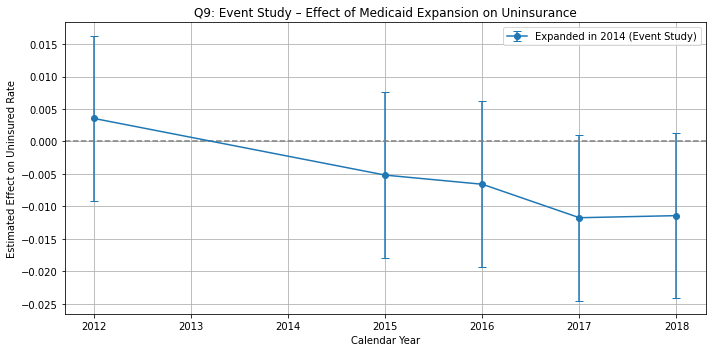

In [28]:
# Subset data to states that expanded in 2014 or never expanded
event_df = df[df['State'].isin(keep_states)].copy()
event_df = event_df.sort_values(['State', 'year'])

# Create event time: years since expansion (0 = 2014)
event_df['event_time'] = event_df['year'] - event_df['expand_year']

# For never-expanded states, assign a fake constant event_time
event_df.loc[event_df['expand_year'].isna(), 'event_time'] = -99

# Create dummy variables for event years -3 to 4 (excluding 0 and -99),
# but rename them without minus signs
for t in range(-3, 5):
    if t == 0:
        continue  # skip reference year
    # Create a new name: if t is negative, use "m" for minus; if positive, "p".
    if t < 0:
        newname = f'event_m{abs(t)}'
    else:
        newname = f'event_p{t}'
    event_df[newname] = (event_df['event_time'] == t).astype(int)

# Build list of new dummy variable names (only include those that were actually created)
event_cols = [col for col in event_df.columns if col.startswith('event_') and col not in ['event_time', 'event_m1']]
#print("Final event columns used in formula:", event_cols)

expanders = event_df[event_df['expand_year'] == 2014]
expanders = expanders.copy()
expanders['uninsured_rate'] = expanders['uninsured'] / expanders['adult_pop']
expanders = expanders[expanders['uninsured_rate'].notna() & ~expanders['uninsured_rate'].isin([float('inf'), float('-inf')])]
#print(expanders[['uninsured', 'adult_pop', 'uninsured_rate']].describe())
non_expanders = event_df[event_df['expand_year'].isna()]

# Estimate separate regressions for expanders and non-expanders
# Recalculate uninsurance rate
expanders = expanders.copy()
expanders['uninsured_rate'] = expanders['uninsured'] / expanders['adult_pop']
expanders = expanders[expanders['uninsured_rate'].notna() & ~expanders['uninsured_rate'].isin([float('inf'), float('-inf')])]
#print(expanders[['uninsured', 'adult_pop', 'uninsured_rate']].describe())

# Set index
expanders = expanders.set_index(['State', 'year'])
# non_expanders = non_expanders.set_index(['State', 'year'])  # Removed

# Add this line before # Build formulas
event_terms = ' + '.join(event_cols)

# Build formulas
expand_formula = f'uninsured_rate ~ {event_terms} + EntityEffects + TimeEffects'
# non_expand_formula = f'uninsured_rate ~ {event_terms} + EntityEffects + TimeEffects'  # Removed

# Run regressions
expand_model = PanelOLS.from_formula(expand_formula, data=expanders, check_rank=False, drop_absorbed=True).fit()
# non_expand_model = PanelOLS.from_formula(non_expand_formula, data=non_expanders, check_rank=False, drop_absorbed=True).fit()  # Removed

# Extract coefficients and errors
expand_coefs = expand_model.params.filter(like='event_')
expand_errors = expand_model.std_errors[expand_coefs.index]


# Convert names to years
def convert_name(name):
    if "m" in name:
        return -int(name.split('m')[1])
    elif "p" in name:
        return int(name.split('p')[1])
    return None

expand_years = [convert_name(name) for name in expand_coefs.index]

# Only build and run model if dummies exist
if event_cols:
    event_terms = ' + '.join(event_cols)
    formula = f'uninsured_rate ~ {event_terms} + EntityEffects + TimeEffects'
    
    # Recalculate uninsurance rate
    event_df['uninsured_rate'] = event_df['uninsured'] / event_df['adult_pop']
    
    # Set panel index for the regression
    event_df = event_df.set_index(['State', 'year'])
    
    # Debug: Print formula and dataframe columns
    #print("EVENT FORMULA:", formula)
    #print("COLUMNS IN DATAFRAME:", event_df.columns.tolist())
    
    # Run the fixed effects regression using PanelOLS
    event_model = PanelOLS.from_formula(formula, data=event_df, check_rank=False, drop_absorbed=True).fit()
    
    # Extract coefficients and standard errors for our event dummies
    coefs = event_model.params.filter(like='event_')
    errors = event_model.std_errors[coefs.index]
    # Convert dummy names back to event time for plotting:
    # e.g., event_m3 becomes -3; event_p1 becomes 1.
    def convert_dummy_name(name):
        suffix = name.split('_')[1]
        if suffix.startswith('m'):
            return -int(suffix[1:])
        elif suffix.startswith('p'):
            return int(suffix[1:])
        else:
            return None
    years = [convert_dummy_name(name) for name in coefs.index]
    
    # Filter out outlier effects if necessary
coefs = coefs.clip(lower=-0.2, upper=0.2)
errors = errors.clip(upper=0.2)            

# Recompute year labels
years = [2014 + e for e in expand_years]

plt.figure(figsize=(10, 5))
plt.errorbar(years, coefs, yerr=1.96 * errors, fmt='o-', capsize=4, label='Expanded in 2014 (Event Study)')
plt.axhline(0, linestyle='--', color='gray')
plt.title("Q9: Event Study – Effect of Medicaid Expansion on Uninsurance")
plt.xlabel("Calendar Year")
plt.ylabel("Estimated Effect on Uninsured Rate")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

\newpage

## **Question 10:** Repeat part 9 but again include states that expanded after 2014. Note: this is tricky…you need to put all states onto “event time” to create this graph.

/var/folders/6z/mn9hb6p56ms_p7_tp4k05vl40000gn/T/ipykernel_87479/2630385980.py:30: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

event_m3

  event_model_q10 = PanelOLS.from_formula(formula_q10, data=event_df_q10, check_rank=False, drop_absorbed=True).fit()


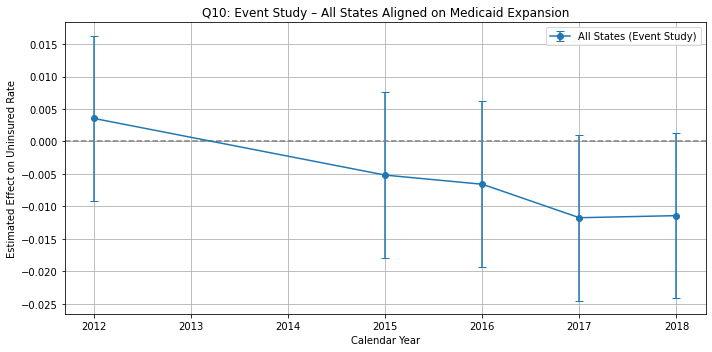

In [29]:
# Include all states (including those that expanded after 2014)
event_df_q10 = df.copy()
event_df_q10 = event_df_q10.sort_values(['State', 'year'])

# Create event time
event_df_q10['event_time'] = event_df_q10['year'] - event_df_q10['expand_year']
event_df_q10.loc[event_df_q10['expand_year'].isna(), 'event_time'] = -99  # constant for never-expanded

# Create dummy variables for event years -3 to +4 (excluding 0 and -99), renamed appropriately
for t in range(-3, 5):
    if t == 0:
        continue
    label = f'event_m{abs(t)}' if t < 0 else f'event_p{t}'
    event_df_q10[label] = (event_df_q10['event_time'] == t).astype(int)

# Build list of event columns
event_cols_q10 = [col for col in event_df_q10.columns if col.startswith('event_') and col not in ['event_time', 'event_m1']]
#print("Q10 Event columns used in formula:", event_cols_q10)

# Prepare formula and set index
event_terms_q10 = ' + '.join(event_cols_q10)
formula_q10 = f'uninsured_rate ~ {event_terms_q10} + EntityEffects + TimeEffects'

# Calculate uninsurance rate
event_df_q10['uninsured_rate'] = event_df_q10['uninsured'] / event_df_q10['adult_pop']
event_df_q10 = event_df_q10[event_df_q10['uninsured_rate'].notna()]
event_df_q10 = event_df_q10.set_index(['State', 'year'])

# Fit model
event_model_q10 = PanelOLS.from_formula(formula_q10, data=event_df_q10, check_rank=False, drop_absorbed=True).fit()

# Extract coefficients and standard errors
coefs_q10 = event_model_q10.params.filter(like='event_')
errors_q10 = event_model_q10.std_errors[coefs_q10.index]

# Convert names to calendar years relative to expansion
def convert_q10(name):
    if "m" in name:
        return 2014 - int(name.split('m')[1])
    elif "p" in name:
        return 2014 + int(name.split('p')[1])
    return None

years_q10 = [convert_q10(name) for name in coefs_q10.index]

# Clip for clarity
coefs_q10 = coefs_q10.clip(lower=-0.2, upper=0.2)
errors_q10 = errors_q10.clip(upper=0.2)

# Plot
plt.figure(figsize=(10, 5))
plt.errorbar(years_q10, coefs_q10, yerr=1.96 * errors_q10, fmt='o-', capsize=4, label='All States (Event Study)')
plt.axhline(0, linestyle='--', color='gray')
plt.title("Q10: Event Study – All States Aligned on Medicaid Expansion")
plt.xlabel("Calendar Year")
plt.ylabel("Estimated Effect on Uninsured Rate")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()